# Use Case: Electricity Consumption of a Single Building

**Dataset**: Half-hourly electricity consumption data from January to April 2024 enriched with weather conditions, historical consumptions and anomaly labels.  
**Time Resolution**: 48 intervals per day (every 30 minutes)  
**Date Range**: January 1, 2024 to April 14, 2024  
**Total Records**: 5,000 half-hourly observations  

---

## Dataset Features

1. **Timestamp**: Date and time of the measurement
2. **Electricity_Consumed**: Electricity consumption in kWh 
3. **Temperature**: Normalized temperature reading (0-1 scale)
4. **Humidity**: Normalized humidity level (0-1 scale)
5. **Wind_Speed**: Normalized wind speed (0-1 scale)
6. **Avg_Past_Consumption**: Historical average consumption for comparison
7. **Anomaly_Label**: Classification of consumption patterns (Normal/Abnormal)

---

## Research Questions

1. How is the electricity consumption from winter to spring?  
2. Can we deduce if the building is a residential or a non-residential building?  


## Why Data Aggregation Matters

In this section, we'll explore how aggregating high-frequency consumption data (half-hourly) to different time scales (hourly, daily, weekly) reduces noise in the data and helps answer questions at the appropriate time scale.

In [32]:
%matplotlib inline

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.dates as mdates
from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Import Data, EDA, and Data Preparation

**Exploratory Data Analysis (EDA)**: Several powerful Python libraries are available for conducting exploratory data analysis. For a comprehensive overview, see: [5 Powerful Python Libraries You Need to Know to Enhance Your EDA Process](http://towardsdatascience.com/5-powerful-python-libraries-you-need-to-know-to-enhance-your-eda-process-f0100d563c16/).

In this notebook, I have used the **ydata-profiling** library (formerly known as pandas-profiling). For detailed documentation, visit the [ydata-profiling documentation](https://docs.profiling.ydata.ai/).

**Note**: Before installing ydata-profiling, you must first install the `ipywidgets` package.

In [3]:
df = pd.read_csv(r"smart_meter_data.csv")
df

,Timestamp,Electricity_Consumed,Temperature,Humidity,Wind_Speed,Avg_Past_Consumption,Anomaly_Label
0,2024-01-01 00:00:00,0.457786,0.469524,0.396368,0.445441,0.692057,Normal
1,2024-01-01 00:30:00,0.351956,0.465545,0.451184,0.458729,0.539874,Normal
2,2024-01-01 01:00:00,0.482948,0.285415,0.408289,0.470360,0.614724,Normal
3,2024-01-01 01:30:00,0.628838,0.482095,0.512308,0.576241,0.757044,Normal
4,2024-01-01 02:00:00,0.335974,0.624741,0.672021,0.373004,0.673981,Normal
...,...,...,...,...,...,...,...
4995,2024-04-14 01:30:00,0.366839,0.701004,0.362397,0.509174,0.490516,Normal
4996,2024-04-14 02:00:00,0.493568,0.258212,0.677895,0.627889,0.535212,Normal
4997,2024-04-14 02:30:00,0.893818,0.431739,0.688926,0.508038,0.681099,Abnormal
4998,2024-04-14 03:00:00,0.509673,0.592927,0.366151,0.668218,0.710599,Normal


In [4]:
# EDA 
'''
ydata-prfoling produces a HTML file with statistic sumamrize and vizualization of each variable (column)
'''
profile = ProfileReport(df, title="UK 2023-2024")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 116.25it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Extracting Temporal Features from Timestamps

**Key temporal features extracted:**
- **Year, Month, Day**: Calendar components for basic temporal grouping
- **Day_name**: Name of the weekday (Monday-Sunday) to analyze weekly patterns
- **Day_of_year**: Sequential day number (1-105) for continuous trend analysis
- **Week**: Start date of each week for weekly aggregations
- **Hour**: Hourly timestamp for hourly consumption patterns
- **Day_Type**: Classification as Weekday or Weekend for behavioral analysis

**Technical Note**: Using `dt.to_period().apply(lambda r: r.start_time)` ensures datetime format compatibility with matplotlib and seaborn for plotting.

In [5]:
# Convert 'Timestamp' column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.dtypes

Timestamp               datetime64[ns]
Electricity_Consumed           float64
Temperature                    float64
Humidity                       float64
Wind_Speed                     float64
Avg_Past_Consumption           float64
Anomaly_Label                   object
dtype: object

In [57]:
#Methdology: dt accessor  and dt.strftime method - extract according to format codes
df["Date"]=df['Timestamp'].dt.strftime('%y-%m-%d')
df["Year"]=df["Timestamp"].dt.year
df["Month"]=df["Timestamp"].dt.month
df["Month_name"]=df["Timestamp"].dt.strftime("%B")
df["Day"]=df["Timestamp"].dt.day
df["Day_name"]=df["Timestamp"].dt.day_name()
df["Day_of_year"]=df["Timestamp"].dt.day_of_year 
df['Day_Type'] = df['Timestamp'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
df['Week'] = df['Timestamp'].dt.to_period('W').apply(lambda r: r.start_time)
df["Day_2"]=df["Timestamp"].dt.to_period("D").apply(lambda r: r.start_time)
df["Hour"]=df["Timestamp"].dt.to_period("H").apply(lambda r: r.start_time)
df

/var/folders/77/thbhtfx5753f1j0bt0__myth0000gn/T/ipykernel_16943/3975201084.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["Hour"]=df["Timestamp"].dt.to_period("H").apply(lambda r: r.start_time)


,Timestamp,Electricity_Consumed,Temperature,Humidity,Wind_Speed,Avg_Past_Consumption,Anomaly_Label,Year,Month,Day,Day_name,Month_name,Day_of_year,Day_Type,Week,Day_2,Hour,date,Date
0,2024-01-01 00:00:00,0.457786,0.469524,0.396368,0.445441,0.692057,Normal,2024,1,1,Monday,January,1,Weekday,2024-01-01,2024-01-01,2024-01-01 00:00:00,24-01-01,24-01-01
1,2024-01-01 00:30:00,0.351956,0.465545,0.451184,0.458729,0.539874,Normal,2024,1,1,Monday,January,1,Weekday,2024-01-01,2024-01-01,2024-01-01 00:00:00,24-01-01,24-01-01
2,2024-01-01 01:00:00,0.482948,0.285415,0.408289,0.470360,0.614724,Normal,2024,1,1,Monday,January,1,Weekday,2024-01-01,2024-01-01,2024-01-01 01:00:00,24-01-01,24-01-01
3,2024-01-01 01:30:00,0.628838,0.482095,0.512308,0.576241,0.757044,Normal,2024,1,1,Monday,January,1,Weekday,2024-01-01,2024-01-01,2024-01-01 01:00:00,24-01-01,24-01-01
4,2024-01-01 02:00:00,0.335974,0.624741,0.672021,0.373004,0.673981,Normal,2024,1,1,Monday,January,1,Weekday,2024-01-01,2024-01-01,2024-01-01 02:00:00,24-01-01,24-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-04-14 01:30:00,0.366839,0.701004,0.362397,0.509174,0.490516,Normal,2024,4,14,Sunday,April,105,Weekend,2024-04-08,2024-04-14,2024-04-14 01:00:00,24-04-14,24-04-14
4996,2024-04-14 02:00:00,0.493568,0.258212,0.677895,0.627889,0.535212,Normal,2024,4,14,Sunday,April,105,Weekend,2024-04-08,2024-04-14,2024-04-14 02:00:00,24-04-14,24-04-14
4997,2024-04-14 02:30:00,0.893818,0.431739,0.688926,0.508038,0.681099,Abnormal,2024,4,14,Sunday,April,105,Weekend,2024-04-08,2024-04-14,2024-04-14 02:00:00,24-04-14,24-04-14
4998,2024-04-14 03:00:00,0.509673,0.592927,0.366151,0.668218,0.710599,Normal,2024,4,14,Sunday,April,105,Weekend,2024-04-08,2024-04-14,2024-04-14 03:00:00,24-04-14,24-04-14


# Time series exploratory analysis

### 1. Raw Data Visualization (No Aggregation)
- **Half-hourly**: Shows granular consumption patterns and variability
- **Hourly**: Reveals daily cycles and time-of-day patterns
- **Daily**: Displays day-to-day variations across the study period

**Note**: Setting `estimator=None` in seaborn plots displays raw values without averaging, preserving the natural variability in the data.

### 2. Aggregated Data Visualization
- **Daily aggregation**: Total consumption per day (sum of 48 half-hourly readings)
- **Weekly aggregation**: Total consumption per week to identify weekly trends
- **Monthly aggregation**: Total consumption per month for seasonal comparison

This multi-scale approach helps identify patterns that may be obscured at higher frequencies.

## Plot without aggregation

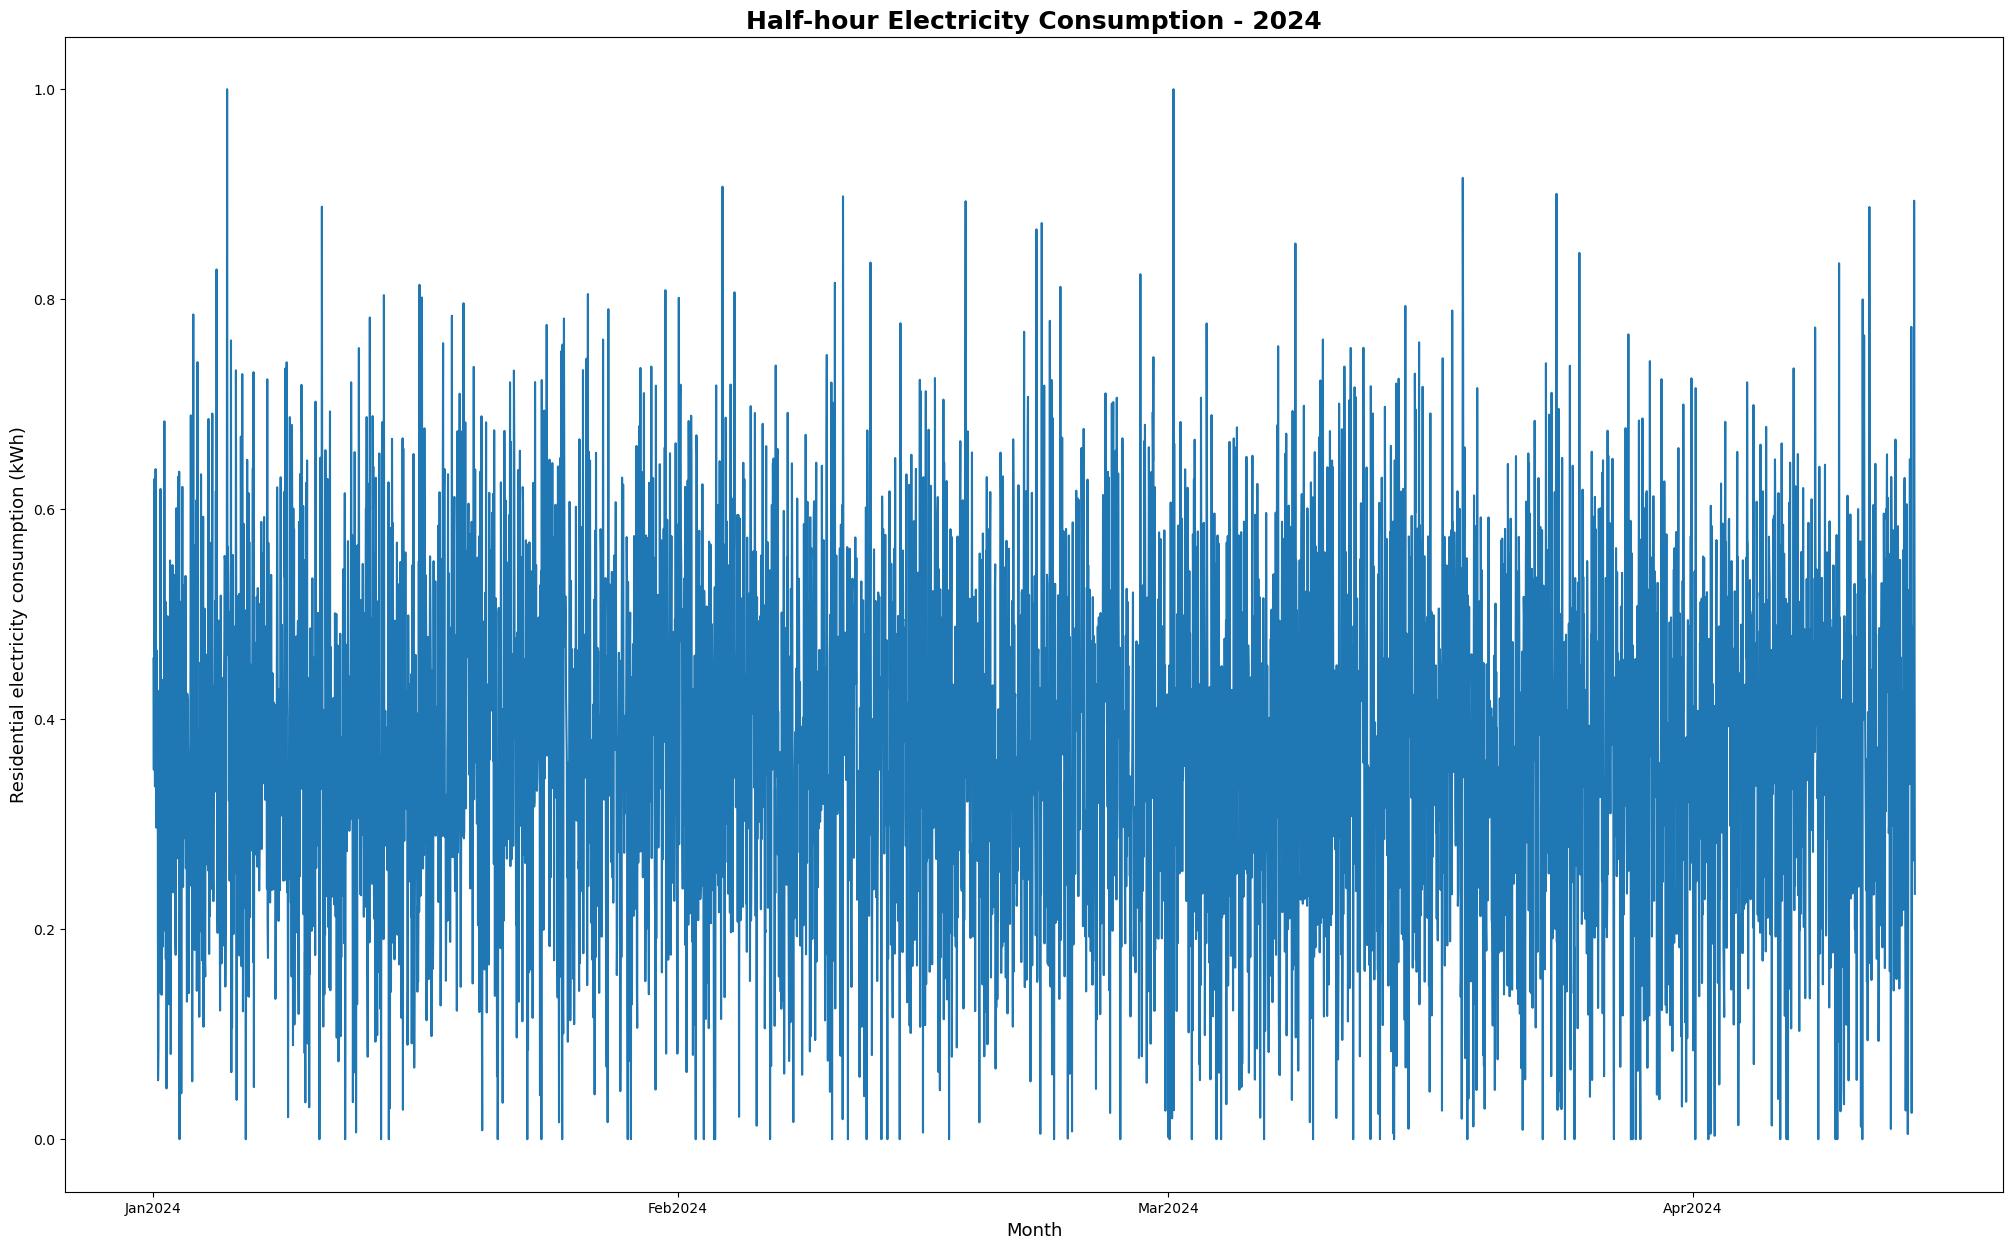

In [12]:
# half-hour

plt.figure(figsize=(25, 15))

sns.lineplot(
    data=df,
    x="Timestamp",
    y="Electricity_Consumed",
    linewidth=1.5
)
# Formatting
plt.xlabel('Month', fontsize=13)
plt.ylabel('Residential electricity consumption (kWh)', fontsize=13)
plt.title('Half-hour Electricity Consumption - 2024', fontsize=18, fontweight='bold')

# Format x-axis to show months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.show()

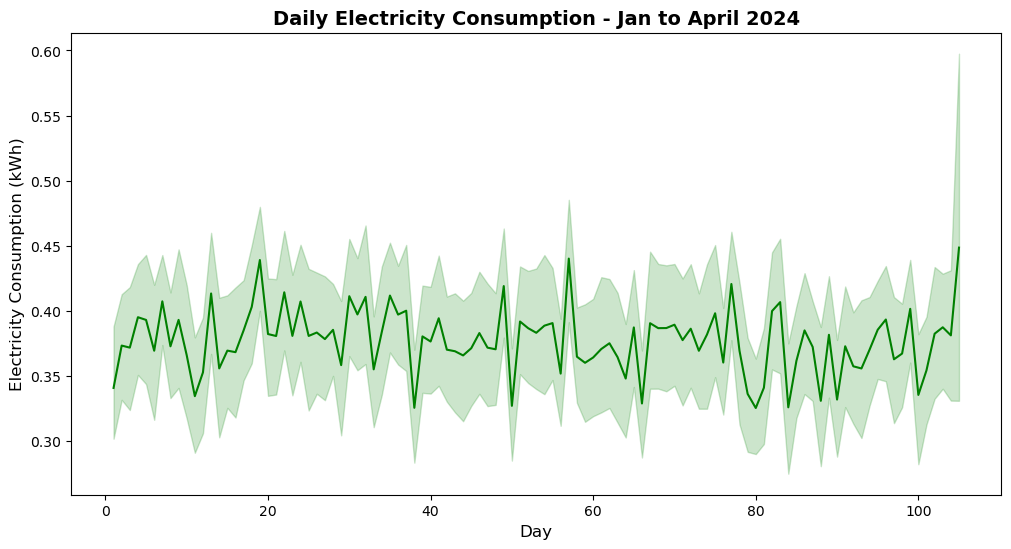

In [20]:
# average daily data
'''
Visualization Type: 
Average electricity consumption per day (mean of 48 half-hourly readings).
The shaded area shows the variability within each day.
'''

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df,
    x="Day_of_year",
    y="Electricity_Consumed",
    estimator = "mean",
    color='green'
)

plt.xlabel('Day', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)
plt.title('Daily Electricity Consumption - Jan to April 2024', fontsize=14, fontweight='bold')

plt.show()


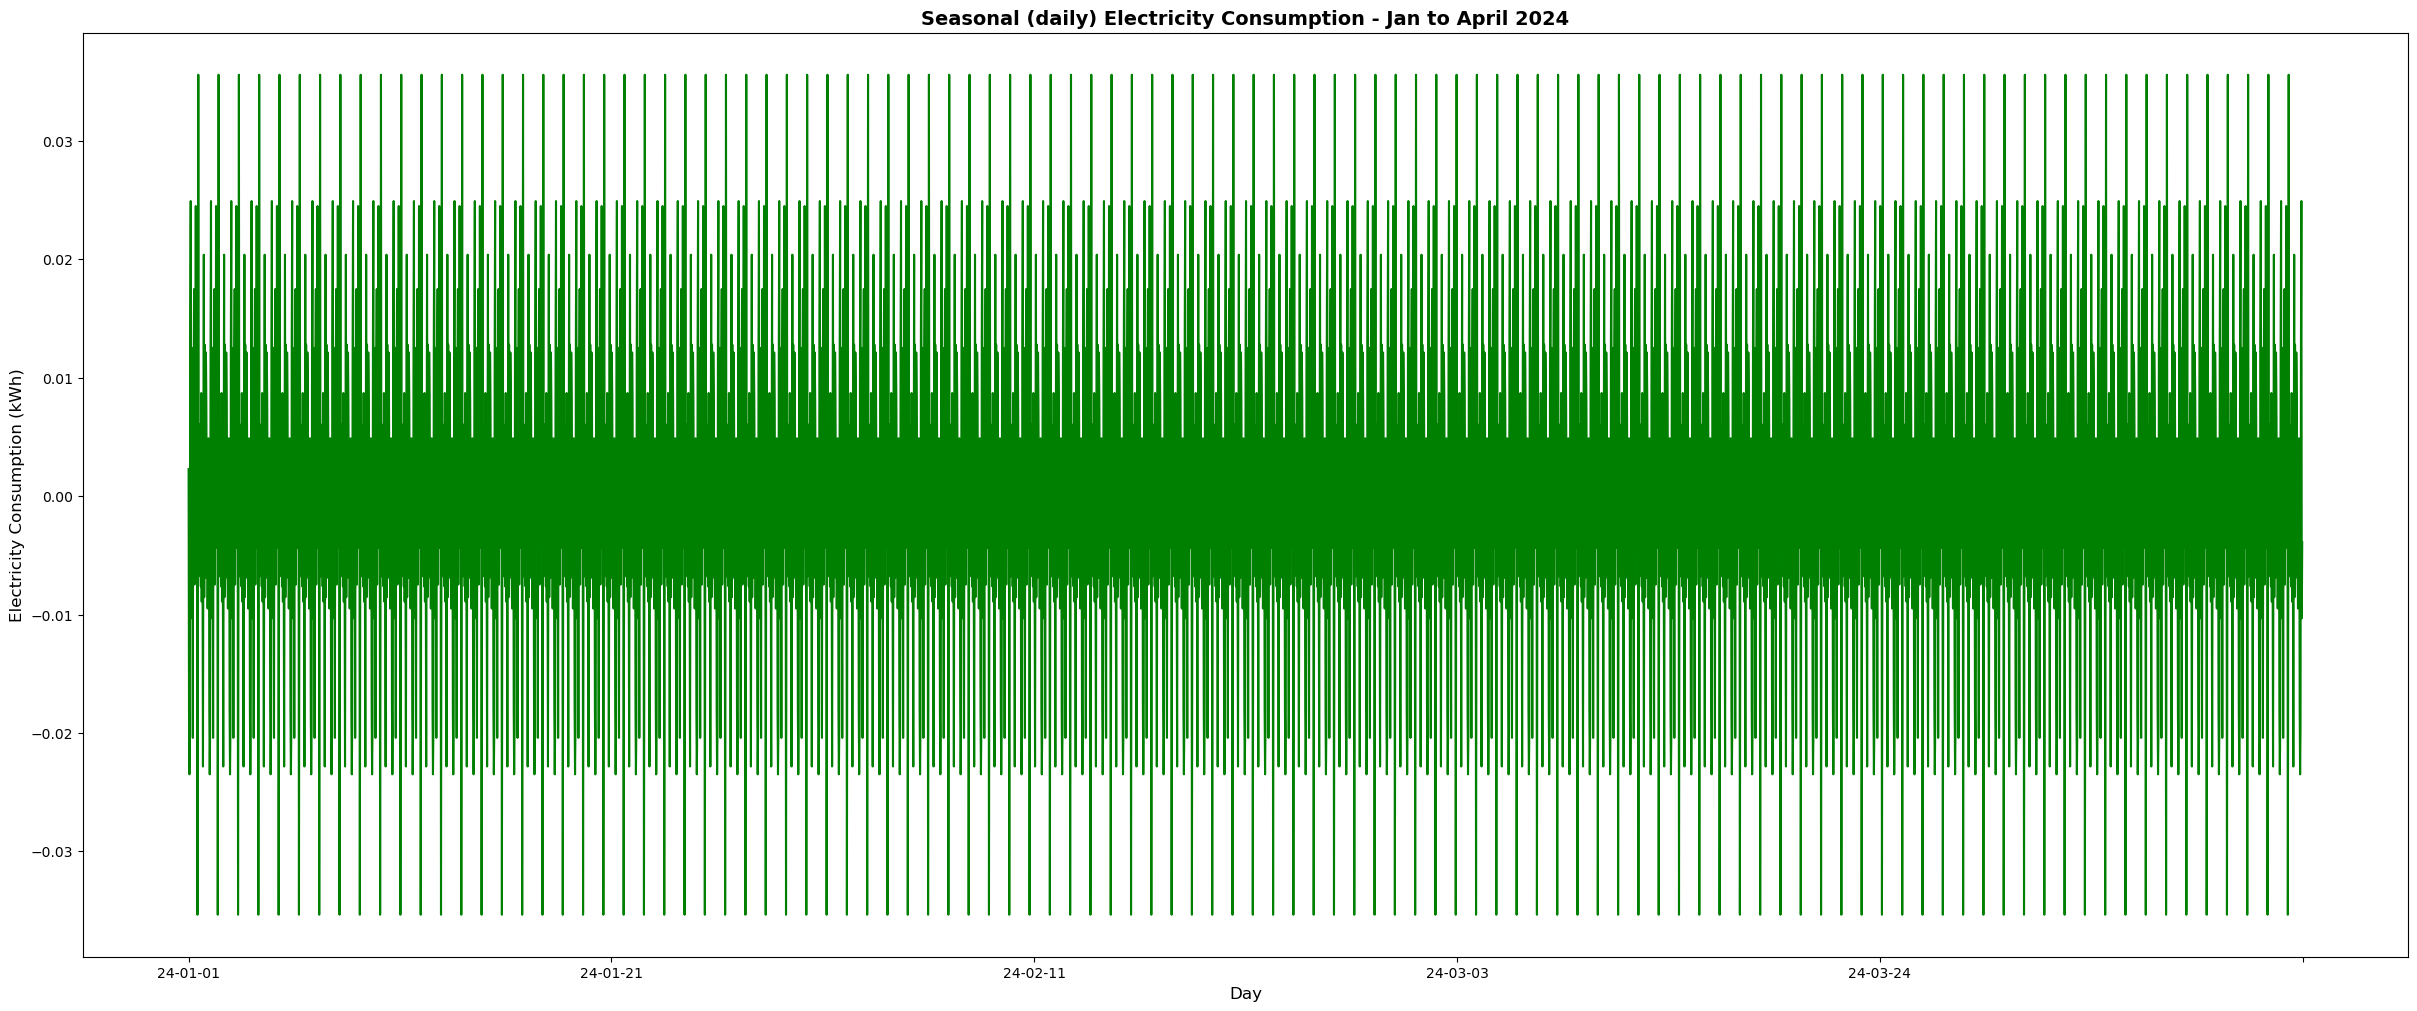

In [76]:
# daily seasonal plot
"""
It shows the seasonal pattern at daily level (48 half-hour cycless)
"""
df_indexed = df.set_index('Date')

decomposition = seasonal_decompose(df_indexed['Electricity_Consumed'], 
                                   model='additive', 
                                   period=48)

plt.figure(figsize=(30,12))
decomposition.seasonal.plot(color="green")

plt.xlabel('Day', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)
plt.title('Seasonal (daily) Electricity Consumption - Jan to April 2024', fontsize=14, fontweight='bold')

plt.show()

## Insights from Raw Data Visualization

The half-hourly and hourly profiles reveal clear **seasonality patterns**:
- **Diurnal variation**: Distinct differences between nighttime and daytime consumption
- **Weekly patterns**: Fluctuations between weekdays and weekends visible
- **High-frequency noise**: Individual readings show significant variability

**Limitation**: While these plots effectively show temporal patterns and rhythms, they don't clearly communicate the **total energy consumed** over specific periods. For understanding total consumption, we need aggregated views.

## Aggregated Consumptions

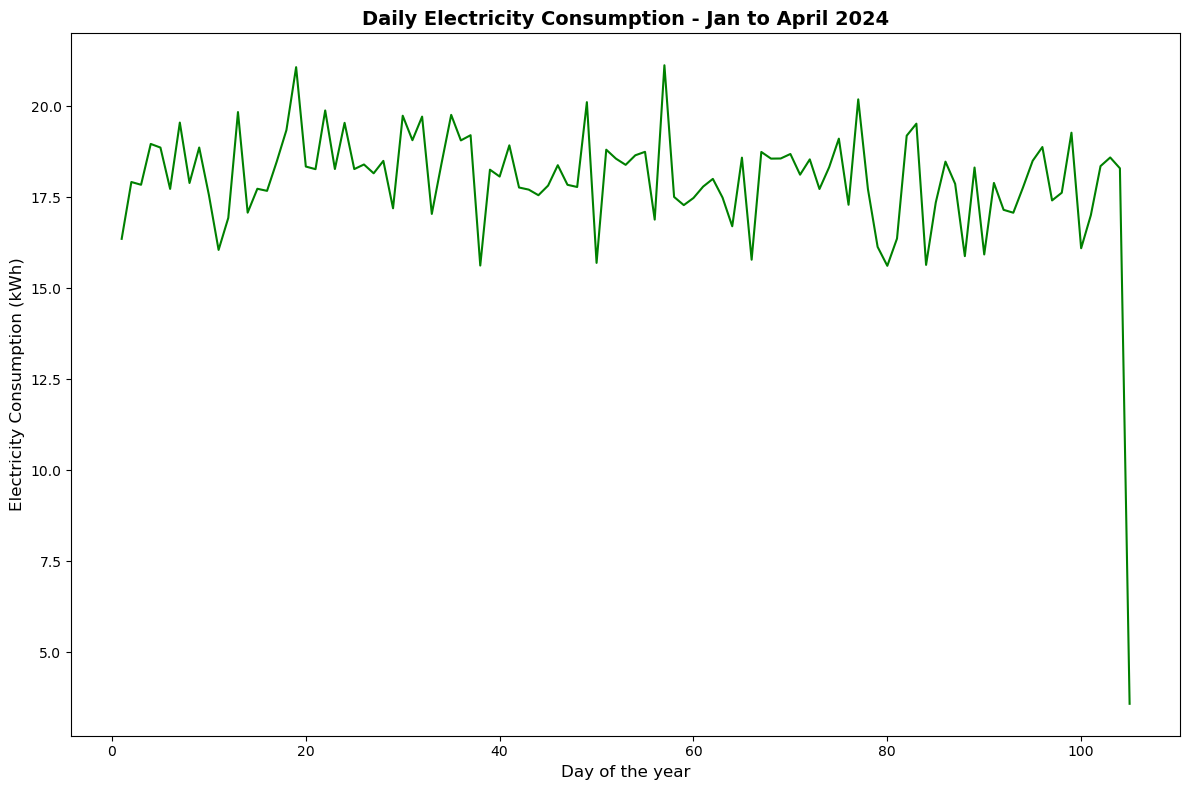

In [21]:
# agggreagted daily consumption

daily = df.groupby("Day_of_year")["Electricity_Consumed"].sum().reset_index()

plt.figure(figsize=(12,8))

sns.lineplot(
    data=daily,
    x="Day_of_year",
    y="Electricity_Consumed",
    color="green")

plt.xlabel('Day of the year', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)
plt.title('Daily Electricity Consumption - Jan to April 2024', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.show()

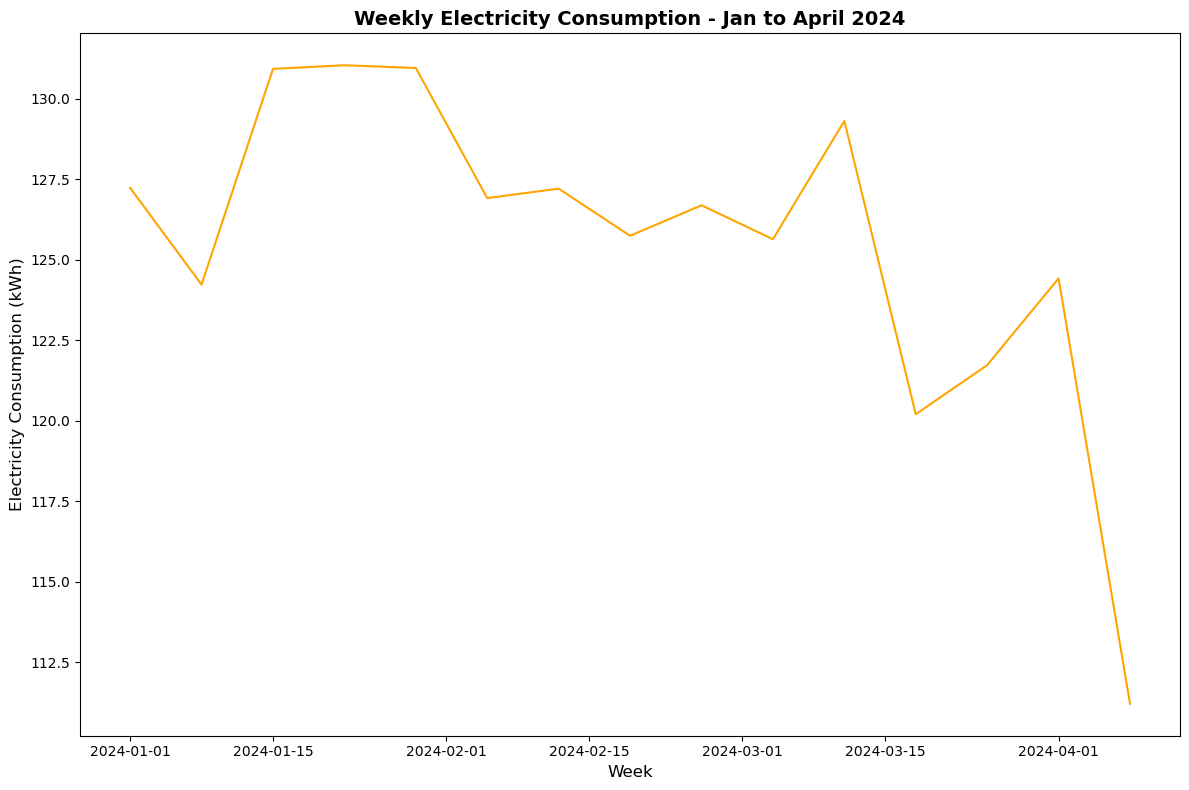

In [22]:
weekly_demand = df.groupby('Week')['Electricity_Consumed'].sum().reset_index()

plt.figure(figsize=(12,8))
sns.lineplot(
    data=weekly_demand,
    x="Week",
    y="Electricity_Consumed",
    color="orange"
) 

plt.xlabel('Week', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)
plt.title('Weekly Electricity Consumption - Jan to April 2024', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.show()

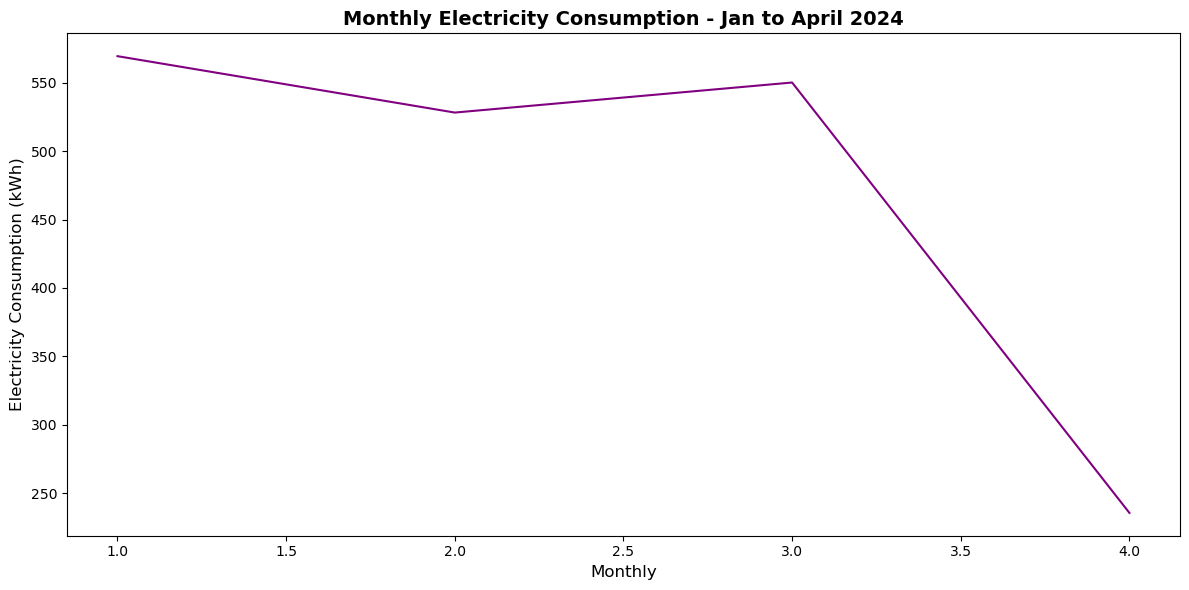

In [25]:
# monthly consumption

monthly_demand = df.groupby("Month")["Electricity_Consumed"].sum().reset_index()

plt.figure(figsize=(12,6))

sns.lineplot(
    data=monthly_demand, 
    x="Month",
    y="Electricity_Consumed",
    color="purple"
)

plt.xlabel('Monthly', fontsize=12)
plt.ylabel('Electricity Consumption (kWh)', fontsize=12)
plt.title('Monthly Electricity Consumption - Jan to April 2024', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.show()

## Insights from Aggregated Data

### Building Type Analysis
Looking at the monthly energy consumption (510-600 kWh/month), this consumption level suggests the building is likely a **commercial or small office building** rather than a residential home.

**Comparison**: 
- Average residential building (4-person household): 290-425 kWh/month
- This building: 510-600 kWh/month (20-40% higher)

### Weekday vs Weekend Patterns
Further analysis of consumption by day of the week helps determine building occupancy patterns and confirm the building type hypothesis.

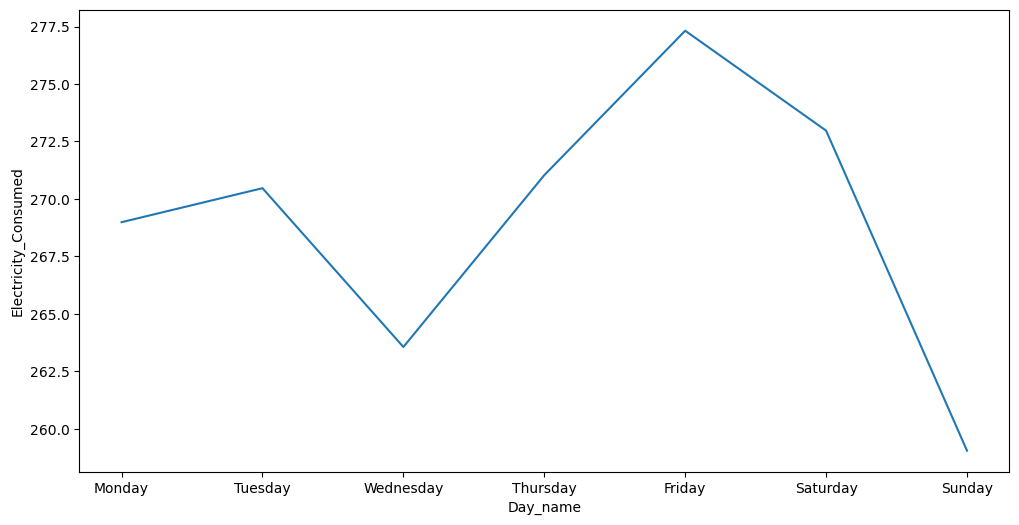

In [115]:
# energy consumption per day name
day_name_demand = df.groupby("Day_name")["Electricity_Consumed"].sum().reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_name_demand['Day_name'] = pd.Categorical(day_name_demand['Day_name'], categories=day_order, ordered=True)
day_name_demand = day_name_demand.sort_values('Day_name')

plt.figure(figsize=(12,6))

sns.lineplot(
    data=day_name_demand, 
    x="Day_name",
    y="Electricity_Consumed",
    
)

plt.show()

# Focused Time Period Analysis

## Analyzing January 2024

To better understand consumption patterns, we'll focus on two timeframes:

1. **Entire month of January** (df_Jan): Provides a representative winter month sample
2. **First week of January** (df_Jan_week1): Allows detailed examination of weekly cycles

This focused analysis helps:
- Identify daily consumption patterns more clearly
- Understand the impact of weekdays vs. weekends
- Examine hourly patterns without visual clutter from multiple months

In [97]:
df_Jan = df[df["Month"] == 1]
df_Jan_week1 =df[df["Week"]=="2024-01-01"]
df_Jan

,Timestamp,Electricity_Consumed,Temperature,Humidity,Wind_Speed,Avg_Past_Consumption,Anomaly_Label,Year,Month,Day,Day_name,week_day,Hour,Week,Day_2,Day_of_year,Day_Type
0,2024-01-01 00:00:00,0.457786,0.469524,0.396368,0.445441,0.692057,Normal,2024,1,1,Monday,0,2024-01-01 00:00:00,2024-01-01,2024-01-01,1,Weekday
1,2024-01-01 00:30:00,0.351956,0.465545,0.451184,0.458729,0.539874,Normal,2024,1,1,Monday,0,2024-01-01 00:00:00,2024-01-01,2024-01-01,1,Weekday
2,2024-01-01 01:00:00,0.482948,0.285415,0.408289,0.470360,0.614724,Normal,2024,1,1,Monday,0,2024-01-01 01:00:00,2024-01-01,2024-01-01,1,Weekday
3,2024-01-01 01:30:00,0.628838,0.482095,0.512308,0.576241,0.757044,Normal,2024,1,1,Monday,0,2024-01-01 01:00:00,2024-01-01,2024-01-01,1,Weekday
4,2024-01-01 02:00:00,0.335974,0.624741,0.672021,0.373004,0.673981,Normal,2024,1,1,Monday,0,2024-01-01 02:00:00,2024-01-01,2024-01-01,1,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,2024-01-31 21:30:00,0.308394,0.481761,0.425515,0.502232,0.478598,Normal,2024,1,31,Wednesday,2,2024-01-31 21:00:00,2024-01-29,2024-01-31,31,Weekday
1484,2024-01-31 22:00:00,0.412447,0.620757,0.408962,0.372177,0.526990,Normal,2024,1,31,Wednesday,2,2024-01-31 22:00:00,2024-01-29,2024-01-31,31,Weekday
1485,2024-01-31 22:30:00,0.530432,0.861688,0.492643,0.328651,0.540618,Normal,2024,1,31,Wednesday,2,2024-01-31 22:00:00,2024-01-29,2024-01-31,31,Weekday
1486,2024-01-31 23:00:00,0.138606,0.495795,0.145906,0.405540,0.478429,Normal,2024,1,31,Wednesday,2,2024-01-31 23:00:00,2024-01-29,2024-01-31,31,Weekday


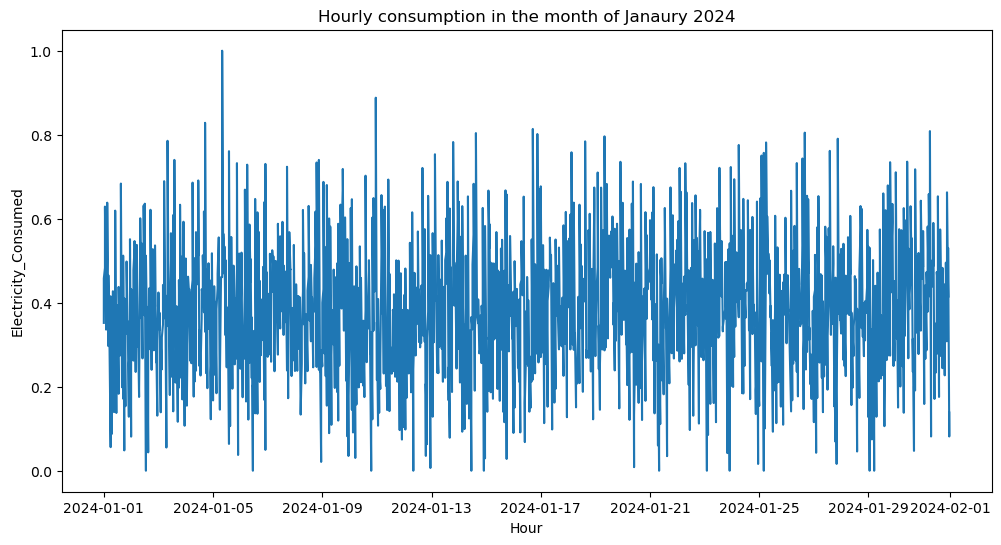

In [98]:
plt.figure(figsize=(12,6))

sns.lineplot(
    data=df_Jan,
    x="Hour",
    y="Electricity_Consumed", 
    estimator=None
)

plt.title("Hourly consumption in the month of Janaury 2024")
plt.show()

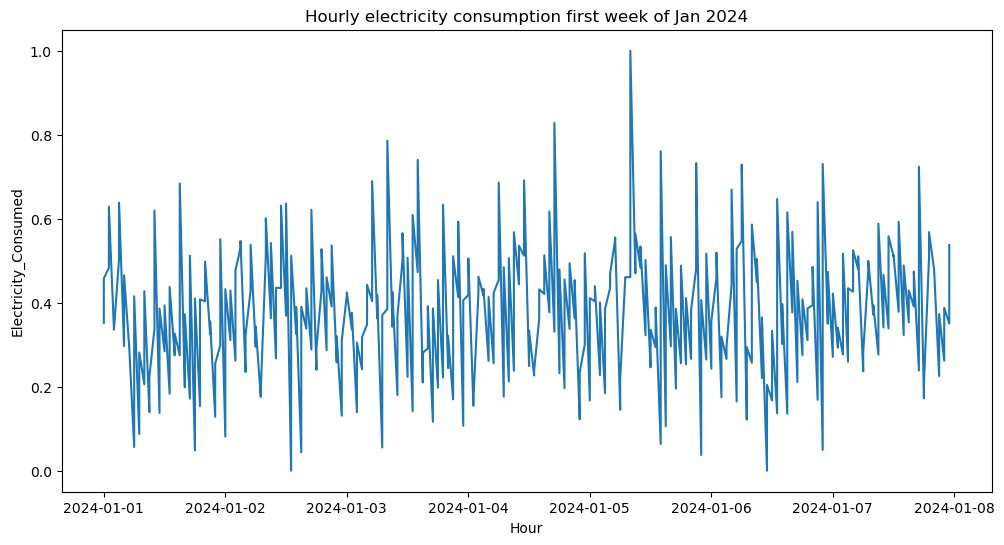

In [99]:
plt.figure(figsize=(12,6))

sns.lineplot(
    data=df_Jan_week1,
    x="Hour",
    y="Electricity_Consumed",
    estimator=None
)

plt.title("Hourly electricity consumption first week of Jan 2024")
plt.show()

## Summary of Research Questions

### 1. How is the electricity consumption from winter to spring?
Based on monthly aggregation analysis:
- **January (Winter)**: Highest consumption period
- **February - April (Transition to Spring)**: Gradual decrease in consumption
- **Seasonal Pattern**: Clear downward trend as temperature increases from winter to spring
- **Interpretation**: Suggests heating demand in winter months, with reduced consumption as weather warms

### 2. Can we deduce if the building is a residential or a non-residential building?
Evidence points to a **commercial/office building**:
- **Monthly consumption**: 510-600 kWh/month (significantly higher than typical residential)
- **Weekday vs Weekend patterns**: Higher consumption during weekdays suggests business operations
- **Hourly patterns**: Peak consumption during business hours (if observed)
- **Conclusion**: Likely a small commercial building or office space

---

## Key Takeaways from Data Aggregation

1. **Multi-scale analysis is essential**: Different time scales reveal different patterns
   - Half-hourly: Shows variability and noise
   - Daily/Weekly: Reveals usage patterns and trends
   - Monthly: Shows seasonal effects

2. **Aggregation reduces noise**: Summing or averaging over time periods helps identify true consumption trends

3. **Context matters**: Understanding building type and occupancy patterns is crucial for interpreting consumption data

4. **Weather is a key driver**: Temperature and other weather factors significantly influence energy consumption patterns